In [1]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 4.9 MB 37.1 MB/s 
     |████████████████████████████████| 213 kB 47.4 MB/s 
     |████████████████████████████████| 90 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 32.2 MB/s 
     |████████████████████████████████| 47.6 MB 1.6 MB/s 
     |████████████████████████████████| 352 kB 54.5 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.5 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 


In [17]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras import layers
from keras import models
import keras

from sklearn.manifold import TSNE

tf.get_logger().setLevel('ERROR')
keras.__version__

'2.7.0'

In [ ]:
# make sure run in GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [5]:
!unzip '/content/student_simulation.zip'

Archive:  /content/student_simulation.zip
  inflating: student_simulation.csv  


In [7]:
df = pd.read_csv('student_simulation.csv')
df = df.drop(columns=['gender','race','international_stu','technical_skill','reading_score'])
df

,Teamwork,Empathy_skills,Self-control,Ability_to_compromise,Ability_to_teach,Respect_for_others,Openness_to_Criticism,Sensitivity_and_Tact,Gaining_trust,Comfort_with_Differences,Listening_Skills
0,87,80,97,75,99,77,91,72,92,76,78
1,85,73,83,79,75,64,76,75,74,84,82
2,89,63,87,87,95,88,72,70,81,90,99
3,80,74,77,89,82,79,93,76,89,72,76
4,66,92,70,78,88,89,77,67,78,75,78
...,...,...,...,...,...,...,...,...,...,...,...
999995,76,82,82,91,79,84,77,78,84,82,77
999996,81,85,85,78,88,85,93,82,68,62,77
999997,85,79,65,77,100,69,91,88,87,70,85
999998,68,85,84,70,73,84,80,83,71,85,66


In [8]:
scaler = StandardScaler()
ds = scaler.fit_transform(df)
ds

array([[ 7.76994115e-01, -1.13892189e-03,  1.88798999e+00, ...,
         1.33125847e+00, -4.45113527e-01, -2.21793222e-01],
       [ 5.55027664e-01, -7.78408417e-01,  3.32559852e-01, ...,
        -6.66544563e-01,  4.42801396e-01,  2.22563292e-01],
       [ 9.98960565e-01, -1.88879341e+00,  7.76968463e-01, ...,
         1.10378840e-01,  1.10873759e+00,  2.11107848e+00],
       ...,
       [ 5.55027664e-01, -1.12177421e-01, -1.66727890e+00, ...,
         7.76313185e-01, -1.11104972e+00,  5.55830678e-01],
       [-1.33168716e+00,  5.54053575e-01,  4.43662005e-01, ...,
        -9.99511736e-01,  5.53790761e-01, -1.55486277e+00],
       [ 1.22092702e+00, -2.22190891e+00, -1.44507459e+00, ...,
         9.98291300e-01, -1.00006035e+00,  3.33652421e-01]])

In [9]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from tensorflow.python.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

In [11]:
inp = Input(shape=(11,1))  
e = Conv1D(4, (11, ), activation='tanh', padding='same')(inp)
e = MaxPooling1D((1, ), padding='same')(e)
e = Conv1D(2, (11, ), activation='tanh', padding='same')(e)
e = MaxPooling1D((1, ), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv1D(2, (11, ), activation='tanh', padding='same')(d)
d = UpSampling1D(1)(d)
d = Conv1D(4, (11, ), activation='tanh', padding='same')(d)
d = UpSampling1D(1)(d)
decoded = Conv1D(1, (11, ), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11, 1)]           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 4)             48        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 11, 4)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 11, 2)             90        
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 11, 2)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 22)                

In [12]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(ds, ds, batch_size=128, epochs=10, validation_data=(ds,ds))

Epoch 1/10
7813/7813 [==============================] - 98s 12ms/step - loss: 0.0157 - val_loss: 2.9560e-04
Epoch 2/10
7813/7813 [==============================] - 96s 12ms/step - loss: 1.8161e-04 - val_loss: 1.1201e-04
Epoch 3/10
7813/7813 [==============================] - 77s 10ms/step - loss: 1.0124e-04 - val_loss: 9.4023e-05
Epoch 4/10
7813/7813 [==============================] - 96s 12ms/step - loss: 7.7403e-05 - val_loss: 5.6597e-05
Epoch 5/10
7813/7813 [==============================] - 76s 10ms/step - loss: 6.5105e-05 - val_loss: 6.6062e-05
Epoch 6/10
7813/7813 [==============================] - 96s 12ms/step - loss: 5.7018e-05 - val_loss: 8.9640e-05
Epoch 7/10
7813/7813 [==============================] - 74s 10ms/step - loss: 5.1861e-05 - val_loss: 3.9417e-05
Epoch 8/10
7813/7813 [==============================] - 75s 10ms/step - loss: 4.7620e-05 - val_loss: 4.5034e-05
Epoch 9/10
7813/7813 [==============================] - 74s 9ms/step - loss: 4.4864e-05 - val_loss: 4.2324e-

In [21]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(ds))

In [22]:
label = pd.DataFrame(y_pred,columns=['label'])
label

,label
0,3
1,1
2,3
3,2
4,1
...,...
999995,3
999996,2
999997,0
999998,1


In [23]:
dd = pd.concat([df, label], axis=1)

In [24]:
filter_data = dd[0:5000]
label = np.array(filter_data.label)
u_labels_filter = np.unique(filter_data.label)

In [25]:
enc = encoder.predict(ds[0:5000])
redu = TSNE(random_state=123).fit_transform(enc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


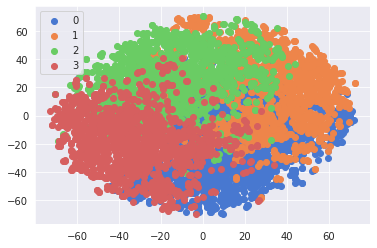

In [26]:
# Plot 5000 samples
for i in u_labels_filter:
    plt.scatter(redu[label==i,0],redu[label==i,1],label=i)
plt.legend()
plt.show()

In [27]:
compression_opts = dict(method='zip', archive_name='skill_data_label.csv')  
dd.to_csv('skill_label.zip', index=False, compression=compression_opts)

In [98]:
table = pd.pivot_table(dd, values=['Teamwork','Empathy_skills','Self-control','Ability_to_compromise',\
                    'Ability_to_teach','Respect_for_others','Openness_to_Criticism','Sensitivity_and_Tact',\
                             'Gaining_trust','Comfort_with_Differences','Listening_Skills'],\
                    index=['label'],
                    aggfunc=[np.mean])
table

mean                   ...                                
      Ability_to_compromise Ability_to_teach  ... Sensitivity_and_Tact   Teamwork
label                                         ...                                
0                 75.747302        79.819552  ...            85.454334  76.646502
1                 78.856119        77.846010  ...            76.140835  75.225232
2                 81.028625        78.014854  ...            75.715293  85.856003
3                 84.291545        84.224302  ...            82.648148  82.389685

[4 rows x 11 columns]

In [91]:
table2 = pd.pivot_table(dd,values='Teamwork',\
                    index=['label'],
                     aggfunc='count')
table2.rename(columns={'Teamwork':'count'}, inplace=True)
table2

,count
label,
0,246658
1,254426
2,244852
3,254064


In [44]:
dd.mean()

Teamwork                    79.998995
Empathy_skills              80.010257
Self-control                80.006720
Ability_to_compromise       80.002193
Ability_to_teach            79.994636
Respect_for_others          79.998842
Openness_to_Criticism       79.993003
Sensitivity_and_Tact        79.987163
Gaining_trust               80.005498
Comfort_with_Differences    80.010416
Listening_Skills            79.996534
label                        1.506322
dtype: float64